# BRCA TGFb-CAF

In [186]:
!pip install statannotations

In [187]:
import pandas as pd
import numpy as np 
import math 
import matplotlib.cm as cm 
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from clinical_analysis.visualizations import visualizations as vis

# adding parent directory to the system path
import sys
sys.path.insert(0, '..')
import utils, plot_utils, stats_utils 

In [188]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


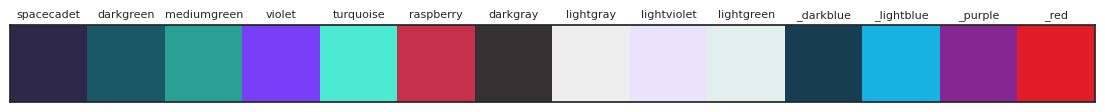

In [189]:
sns.set(style='white',font_scale=1.3)

pa_colors = pd.Series({'spacecadet': '#2D2849',
 'darkgreen': '#195866',
 'mediumgreen': '#2AA095',
 'violet': '#793EF8',
 'turquoise': '#4CEAD3',
 'raspberry': '#C5304B',
 'darkgray': '#333132',
 'lightgray': '#EEEEEE',
 'lightviolet': '#EBE2FE',
 'lightgreen': '#E1EFED',
 '_darkblue': '#173D52',
 '_lightblue': '#16B2E1',
 '_purple': '#852693',
 '_red': '#E11C29'})

sns.palplot(pa_colors)
ax = plt.gca()
for i, name in enumerate(pa_colors.index):
    ax.text(i, -0.6, name, fontsize=8, ha='center')     
plt.show()

In [190]:
colormap_tgfbeta = {r'TGFb-CAF high': pa_colors['turquoise'], 
                    'TGFb-CAF low': pa_colors['violet']}

## Read in data

Read in data:

In [191]:
hifs = pd.read_csv('data/harmonized_tme_hifs_test_set_only.csv').set_index('H & E_ID')
model_pred_binary = hifs.pop('model_prediction')
actual_class = hifs.pop('Class')
model_prediction = model_pred_binary.replace({0: 'TGFb-CAF low', 1: 'TGFb-CAF high'})

In [193]:
hifs.shape

(214, 297)

Exclude `SELECTED BY` and `DENSITY RATIO` HIFs.

In [194]:
hifs_reduced = hifs.loc[:, ~hifs.columns.str.contains('(SELECTED BY|DENSITY RATIO)')]

/tmp/ipykernel_2502/496336120.py:1: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



## Compare distributions

In [195]:
_, df_mwh = stats_utils.compare_hif_distributions(hifs_reduced, model_prediction)

In [196]:
df_mwh['cell'] = df_mwh.index.map(utils.get_cell) 
df_mwh['tissue'] = df_mwh.index.map(utils.get_tissue) 
df_mwh['hif type'] = df_mwh.index.map(utils.get_hif_type)

### Mann-Whitney U Test

Mann-Whitney U test results showing the top 10 HIFs:

In [197]:
df_mwh.iloc[:10, :].round(3)

,statistic,pvalue,pvalue_corrected,cell,tissue,hif type
COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E,9076.0,0.0,0.0,FIBROBLAST,HARMONIZED TUMOR,COUNT PROP
COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,9062.0,0.0,0.0,FIBROBLAST,CANCER STROMA,COUNT PROP
DENSITY [FIBROBLAST CELLS] IN [HARMONIZED TUMOR]_H & E,9049.0,0.0,0.0,FIBROBLAST,HARMONIZED TUMOR,DENSITY
DENSITY [MACROPHAGE CELLS] IN [CANCER STROMA]_H & E,411.0,0.0,0.0,MACROPHAGE,CANCER STROMA,DENSITY
COUNT PROP [[MACROPHAGE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,466.0,0.0,0.0,MACROPHAGE,CANCER STROMA,COUNT PROP
COUNT PROP [[HARMONIZED IMMUNE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,488.0,0.0,0.0,HARMONIZED IMMUNE,CANCER STROMA,COUNT PROP
DENSITY [FIBROBLAST CELLS] IN [CANCER]_H & E,8589.0,0.0,0.0,FIBROBLAST,CANCER,DENSITY
COUNT PROP [[LYMPHOCYTE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,559.0,0.0,0.0,LYMPHOCYTE,CANCER STROMA,COUNT PROP
DENSITY [FIBROBLAST CELLS] IN [CANCER STROMA]_H & E,8559.0,0.0,0.0,FIBROBLAST,CANCER STROMA,DENSITY
COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E,8455.0,0.0,0.0,FIBROBLAST,CANCER,COUNT PROP


In [198]:
cell_types = ['FIBROBLAST', 'CANCER', 'LYMPHOCYTE',  'PLASMA',
              'MACROPHAGE', 'HARMONIZED IMMUNE']
cell_types_labels = ['Fibroblast\ncells', 'Cancer\ncells',  'Lymphocyte\ncells','Plasma\ncells', 
                     'Macrophage\ncells', 'Immune\ncells']
tissue_types = ['HARMONIZED TUMOR', 'CANCER', 'CANCER STROMA']
tissue_type_labels = ['Tumor', 'Cancer', 'Cancer stroma']

## Visualize area prop HIF

In [199]:
hifs.filter(regex='AREA PROP')

,AREA PROP [[CANCER STROMA] OVER [HARMONIZED TISSUE]]_H & E,AREA PROP [[CANCER STROMA] OVER [HARMONIZED TUMOR]]_H & E,AREA PROP [[CANCER] OVER [HARMONIZED TISSUE]]_H & E,AREA PROP [[CANCER] OVER [HARMONIZED TUMOR]]_H & E,AREA PROP [[HARMONIZED TUMOR] OVER [HARMONIZED TISSUE]]_H & E,AREA PROP [[NECROSIS] OVER [HARMONIZED TISSUE]]_H & E
H & E_ID,,,,,,
89379,0.875544,0.882393,0.116694,0.117607,0.992238,0.007762
82820,0.748231,0.749995,0.249417,0.250005,0.997648,0.002352
80671,0.767714,0.783879,0.211664,0.216121,0.979378,0.020622
87724,0.791863,0.793893,0.205580,0.206107,0.997443,0.002557
82087,0.780919,0.785080,0.213781,0.214920,0.994700,0.005300
...,...,...,...,...,...,...
82306,0.716831,0.723848,0.273475,0.276152,0.990306,0.009694
88813,0.229571,0.233151,0.755075,0.766849,0.984646,0.015354
86017,0.101259,0.102192,0.889618,0.897808,0.990878,0.009122


In [200]:
np.unique(model_prediction)

array(['TGFb-CAF high', 'TGFb-CAF low'], dtype=object)

In [201]:
tissue_types = ['CANCER', 'CANCER STROMA', 'NECROSIS']
tissue_types_labels = ['Cancer', 'Cancer stroma', 'Necrosis']
areaprop_feats = [f'AREA PROP [[{tissue}] OVER [HARMONIZED TISSUE]]_H & E' for tissue in tissue_types] 
tissue_colors = ('#D500FA', '#FBB830', '#000000')


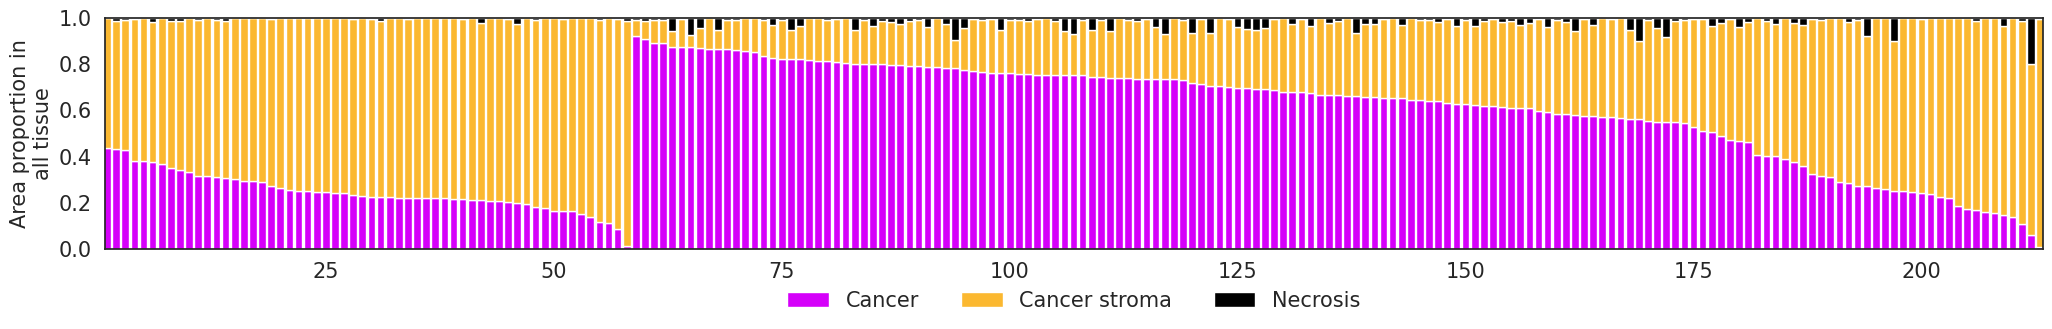

In [202]:

plot_utils.plot_stacked_barplots(hifs, 
                                 model_prediction, 
                                 areaprop_feats, 
                                 figsize=(25,3),
                                 colors=tissue_colors,
                                 ylab='Area proportion in\nall tissue',
                                 legend_labels=tissue_types_labels,
                                 ymax=1)
                                 #fname='output/fig_3b_barplot_areaprop_harmonized.svg')#,
                                 #format='eps')

CANCER STROMA_TGFb-CAF high vs. CANCER STROMA_TGFb-CAF low: ***
CANCER_TGFb-CAF high vs. CANCER_TGFb-CAF low: ***
NECROSIS_TGFb-CAF high vs. NECROSIS_TGFb-CAF low: **


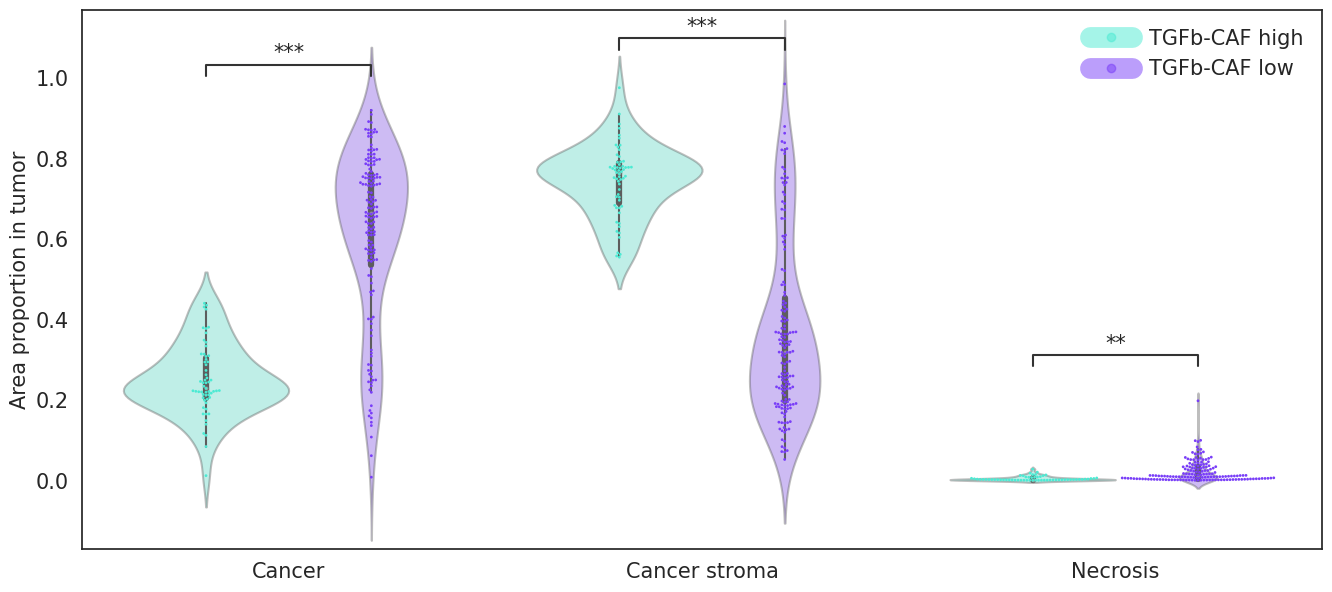

In [204]:
import plot_utils

plot_utils.violinplots_hifs_by_group(hifs, 
                                  df_mwh, 
                                  '^AREA PROP \[\[(CANCER STROMA|CANCER|NECROSIS)\] OVER \[HARMONIZED TISSUE\]\]_H & E',
                                  model_prediction, 
                                  colormap_tgfbeta,
                                  tissue_types, 
                                  groupx_name='tissue',
                                  groupx_labels=tissue_types_labels, 
                                  ylabel='Area proportion in tumor')

## Visualize count prop HIF in high attention regions

### Tumor (cancer + cancer stroma)

In [205]:
cell_types = [ 'CANCER', 'FIBROBLAST', 'PLASMA', 'LYMPHOCYTE',  
              'MACROPHAGE']
cell_types_labels = ['Cancer cells', 'Fibroblast cells',  'Plasma cells', 'Lymphocyte cells',
                     'Macrophage cells']
cell_types_colors = ['#F93A00', '#FB8741',  '#FFEEAC', '#36B279', '#015f7d'] #'#00AFE7']

In [206]:
np.unique(model_prediction)

array(['TGFb-CAF high', 'TGFb-CAF low'], dtype=object)

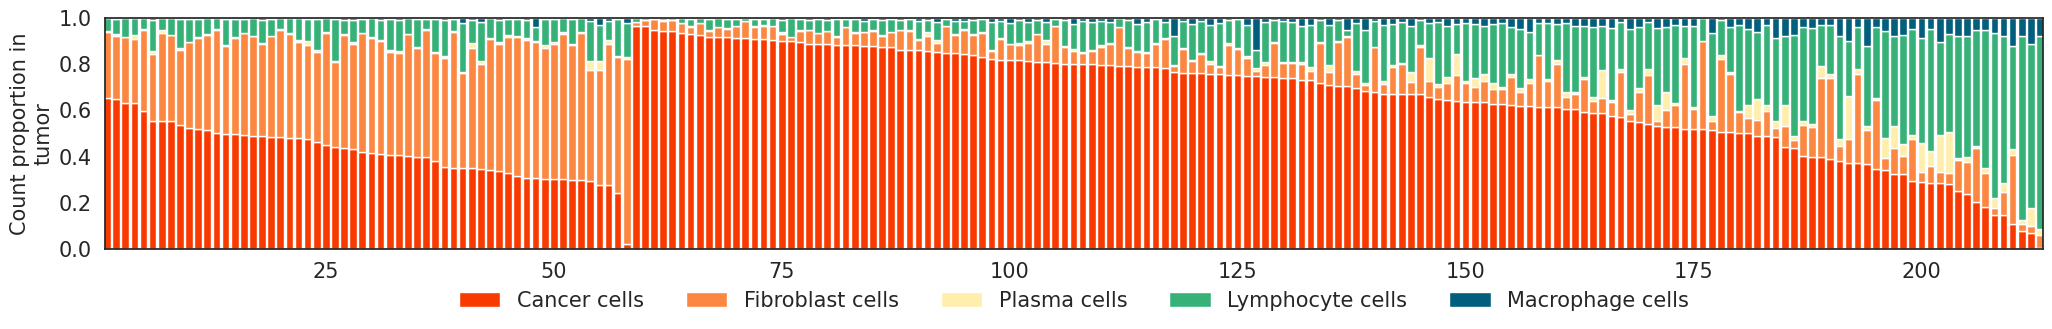

In [207]:
countprop_feats = [f'COUNT PROP [[{cell} CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E' for cell in cell_types] 

plot_utils.plot_stacked_barplots(hifs, 
                                 model_prediction, 
                                 countprop_feats, 
                                 figsize=(25,3),
                                 colors=cell_types_colors,
                                 ylab='Count proportion in\ntumor',
                                 ymax=1, 
                                 legend_labels=cell_types_labels)

### Cancer stroma

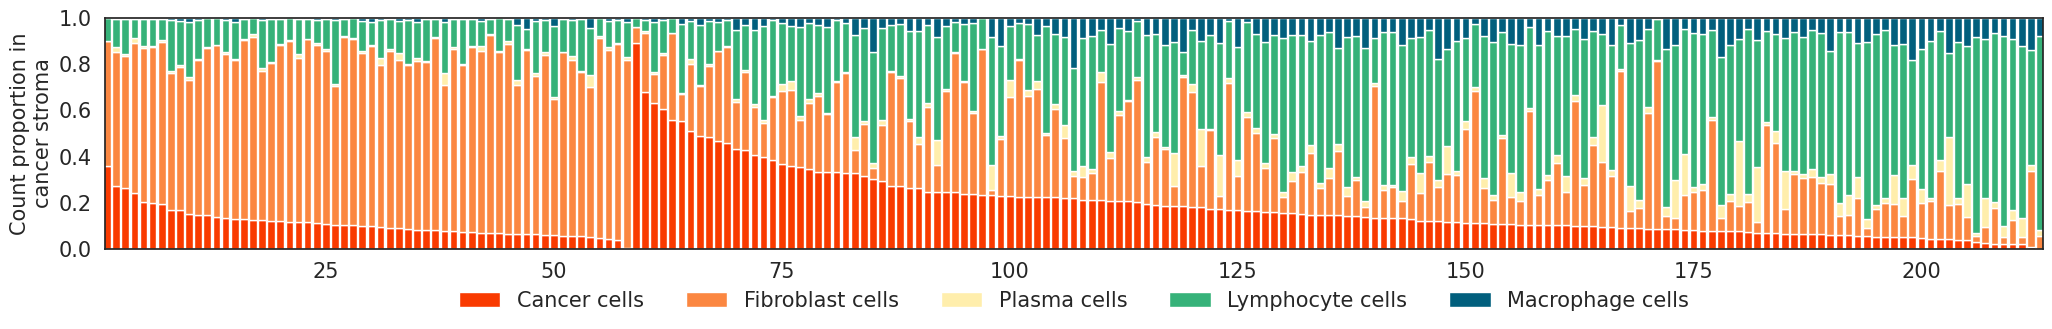

In [208]:
countprop_feats = [f'COUNT PROP [[{cell} CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E' for cell in cell_types] 

plot_utils.plot_stacked_barplots(hifs, 
                                 model_prediction, 
                                 countprop_feats, 
                                 figsize=(25,3),
                                 colors=cell_types_colors,
                                 ylab='Count proportion in\ncancer stroma',
                                 ymax=1, 
                                 legend_labels=cell_types_labels)

In [209]:
df_mwh.filter(regex='COUNT PROP \[\[.*\] OVER \[HARMONIZED ALL PREDICTED CELLS\]\] IN \[CANCER STROMA\]_H & E', axis=0)

,statistic,pvalue,pvalue_corrected,cell,tissue,hif type
COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,9062.0,1.403840e-28,3.616486e-27,FIBROBLAST,CANCER STROMA,COUNT PROP
COUNT PROP [[MACROPHAGE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,466.0,3.532765e-24,3.815387e-23,MACROPHAGE,CANCER STROMA,COUNT PROP
COUNT PROP [[HARMONIZED IMMUNE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,488.0,6.154554e-24,5.539099e-23,HARMONIZED IMMUNE,CANCER STROMA,COUNT PROP
COUNT PROP [[LYMPHOCYTE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,559.0,3.618798e-23,2.442688e-22,LYMPHOCYTE,CANCER STROMA,COUNT PROP
COUNT PROP [[PLASMA CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,1674.0,8.101834e-13,1.822913e-12,PLASMA,CANCER STROMA,COUNT PROP
COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,3290.0,1.539450e-03,1.979293e-03,CANCER,CANCER STROMA,COUNT PROP


Some TGFb-CAF low predicted slides have high count prop of cancer cells in cancer stroma.

In [210]:
columns_of_interest = ['AREA PROP [[CANCER STROMA] OVER [HARMONIZED TUMOR]]_H & E_contribution_patches', 
                       'AREA PROP [[CANCER] OVER [HARMONIZED TUMOR]]_H & E_contribution_patches',
                       'COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E_contribution_patches',
                       'COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E_contribution_patches',
                       'model_prediction',
                       'Class',
                       ]

In [211]:
hifs_reduced_temp.loc[((hifs_reduced_temp['COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E_contribution_patches'] > 0.5) & (hifs_reduced_temp['model_prediction'] == 0)), 
                columns_of_interest]

,AREA PROP [[CANCER STROMA] OVER [HARMONIZED TUMOR]]_H & E_contribution_patches,AREA PROP [[CANCER] OVER [HARMONIZED TUMOR]]_H & E_contribution_patches,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E_contribution_patches,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E_contribution_patches,model_prediction,Class
H & E_ID,,,,,,
91702,0.233940,0.766060,0.971076,0.632116,0,0
82529,0.232505,0.767495,0.984376,0.890686,0,0
90116,0.131656,0.868344,0.975402,0.556101,0,0
86618,0.148051,0.851949,0.927418,0.551957,0,0
90521,0.323993,0.676007,0.952485,0.605910,0,1
82634,0.180283,0.819717,0.943252,0.510480,0,0
84719,0.248303,0.751697,0.981526,0.678968,0,0


Compare with TGFb-CAF low predicted slides have low count prop of cancer cells in cancer stroma

In [212]:
hifs_reduced_temp.loc[((hifs_reduced_temp['COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E_contribution_patches'] < 0.2) & (hifs_reduced_temp['model_prediction'] == 0)), 
                columns_of_interest]

,AREA PROP [[CANCER STROMA] OVER [HARMONIZED TUMOR]]_H & E_contribution_patches,AREA PROP [[CANCER] OVER [HARMONIZED TUMOR]]_H & E_contribution_patches,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E_contribution_patches,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E_contribution_patches,model_prediction,Class
H & E_ID,,,,,,
82531,0.148226,0.851774,0.921661,0.105807,0,0
87439,0.209760,0.790240,0.925271,0.109720,0,0
88821,0.368207,0.631793,0.884974,0.102086,0,1
82255,0.240920,0.759080,0.910412,0.146282,0,0
85839,0.282083,0.717917,0.866231,0.120019,0,1
...,...,...,...,...,...,...
85911,0.705334,0.294666,0.925534,0.042592,0,0
86861,0.780517,0.219484,0.753801,0.022207,0,1
91479,0.344375,0.655625,0.778327,0.089336,0,0


## Visualize count prop HIF by cell type

Annotation (`ns`, `*`, `**`, `***`) is based on Mann-Whitney U test results
- `ns`: FDR adjusted p-value >= 0.05
- `*`: FDR adjusted p-value < 0.05
- `**`: FDR adjusted p-value < 1e-5
- `***`: FDR adjusted p-value < 1e-10
- `****`: FDR adjusted p-value < 1e-20

In [213]:
cell_types = ['CANCER', 'FIBROBLAST', 'PLASMA', 'LYMPHOCYTE',  
              'MACROPHAGE']
cell_types_labels = ['Cancer cells', 'Fibroblast cells',  'Plasma cells', 'Lymphocyte cells',
                     'Macrophage cells']

### Tumor

FIBROBLAST_TGFb-CAF high vs. FIBROBLAST_TGFb-CAF low: ****
CANCER_TGFb-CAF high vs. CANCER_TGFb-CAF low: ***
PLASMA_TGFb-CAF high vs. PLASMA_TGFb-CAF low: ns
LYMPHOCYTE_TGFb-CAF high vs. LYMPHOCYTE_TGFb-CAF low: *
MACROPHAGE_TGFb-CAF high vs. MACROPHAGE_TGFb-CAF low: ***


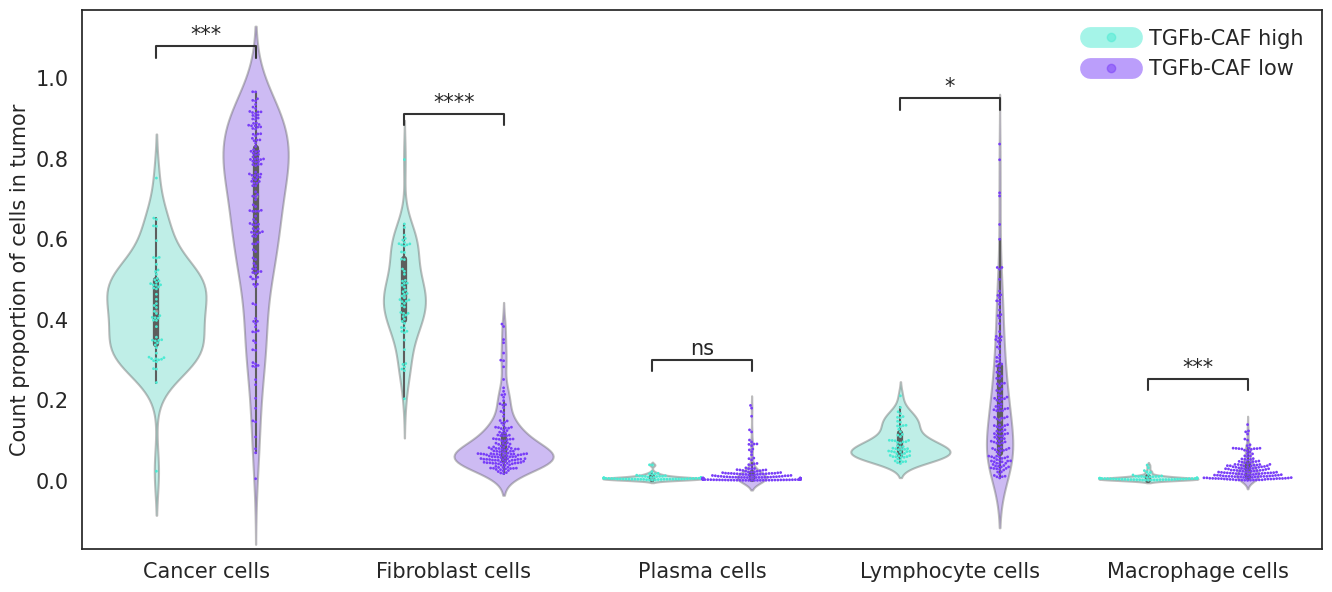

In [214]:
plot_utils.violinplots_hifs_by_group(hifs, df_mwh, 
                                 '^COUNT PROP.*OVER \[HARMONIZED ALL PREDICTED CELLS\]\] IN \[HARMONIZED TUMOR\]_H & E',
                                 model_prediction, 
                                 colormap_tgfbeta,
                                 cell_types, 
                                 groupx_labels=cell_types_labels, 
                                 ylabel='Count proportion of cells in tumor')

### Cancer stroma

Count proportion of each cell type in cancer stroma:


FIBROBLAST_TGFb-CAF high vs. FIBROBLAST_TGFb-CAF low: ****
CANCER_TGFb-CAF high vs. CANCER_TGFb-CAF low: *
PLASMA_TGFb-CAF high vs. PLASMA_TGFb-CAF low: ***
LYMPHOCYTE_TGFb-CAF high vs. LYMPHOCYTE_TGFb-CAF low: ****
MACROPHAGE_TGFb-CAF high vs. MACROPHAGE_TGFb-CAF low: ****


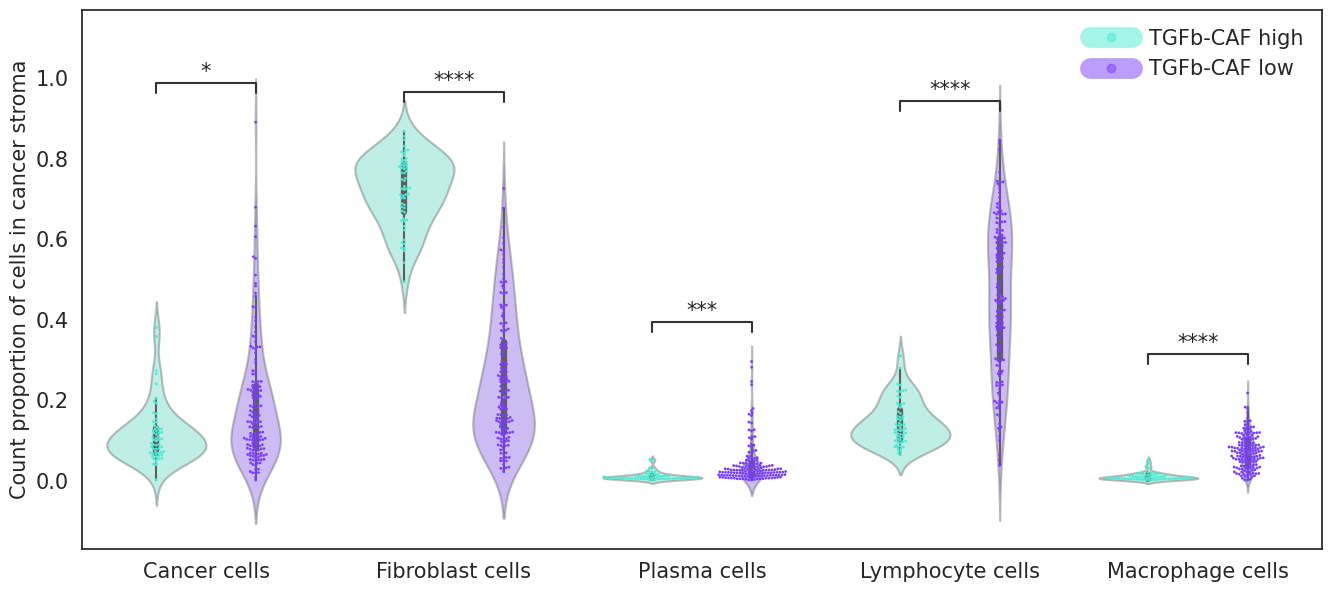

In [215]:
plot_utils.violinplots_hifs_by_group(hifs, df_mwh, 
                                 '^COUNT PROP.*OVER \[HARMONIZED ALL PREDICTED CELLS\]\] IN \[CANCER STROMA\]_H & E',
                                 model_prediction, 
                                 colormap_tgfbeta,
                                 cell_types, 
                                 groupx_labels=cell_types_labels, 
                                 ylabel='Count proportion of cells in cancer stroma')

## PCA

In [216]:
hifs_reduced = hifs.loc[:, ~hifs.columns.str.contains('(SELECTED BY|DENSITY RATIO)')]

/tmp/ipykernel_2502/496336120.py:1: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [217]:
n_components = 10
#nuhifs_cell_specific = nuhifs.filter(regex='CANCER CELL')
pipeline = Pipeline([('scaler', StandardScaler()), ('imputer', KNNImputer()), ('pca', PCA(n_components=n_components))])
pca_data = pipeline.fit_transform(hifs_reduced)
pca_data = pd.DataFrame(pca_data, index=hifs_reduced.index, columns=[f'PC{i}' for i in np.arange(1, 11)])
pca_data = pca_data.merge(model_prediction, on='H & E_ID')

In [218]:
pca_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,model_prediction
H & E_ID,,,,,,,,,,,
89379,-4.206383,5.269541,1.322724,0.324166,-0.015169,0.259545,0.565491,0.629550,0.349602,0.590273,TGFb-CAF high
82820,-4.167953,3.335839,-1.344471,1.015306,0.690075,0.949265,0.172256,-0.439880,-1.134375,0.250203,TGFb-CAF high
80671,-0.943700,4.514204,-3.988156,0.349893,-1.091259,-0.084970,0.722808,-0.447705,-0.204506,0.961043,TGFb-CAF high
87724,-4.335012,5.562937,-1.193054,-1.272988,0.584548,0.428448,0.409364,0.870363,-1.921579,0.286441,TGFb-CAF high
82087,-4.118719,3.107892,-0.051346,-0.587914,0.484112,1.674715,0.334681,-0.360801,-0.670132,-0.333136,TGFb-CAF high
...,...,...,...,...,...,...,...,...,...,...,...
82306,-0.982511,1.507499,-2.146905,3.601943,1.225073,0.301198,-1.147642,-0.559081,1.679939,-1.488486,TGFb-CAF low
88813,0.365291,-1.547455,0.380124,2.239732,-1.937305,-0.877227,-0.108750,0.984565,-0.425447,0.444618,TGFb-CAF low
86017,-3.117781,-4.526000,2.842225,-2.597304,1.353801,-0.128148,-0.431134,1.371630,-0.685617,0.092025,TGFb-CAF low


In [219]:
pca_step = pipeline.steps[2][1]

In [220]:
topfeats = pd.DataFrame({'PC': [f'PC{i}' for i in np.arange(1, n_components+1)], 
                         'feature': hifs_reduced.columns[np.argmax(np.abs(pca_step.components_), axis=1)],
                         'loading': list(map(lambda x: max(x, key=abs), pca_step.components_))})
topfeats = topfeats.set_index('PC')
topfeats['cell'] = topfeats['feature'].map(utils.get_cell)
topfeats['tissue'] = topfeats['feature'].map(utils.get_tissue)
topfeats['hif type'] = topfeats['feature'].map(utils.get_hif_type)

In [221]:
topfeats

,feature,loading,cell,tissue,hif type
PC,,,,,
PC1,DENSITY [HARMONIZED IMMUNE CELLS] IN [CANCER S...,0.208901,HARMONIZED IMMUNE,CANCER STROMA,DENSITY
PC2,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED AL...,-0.277406,CANCER,HARMONIZED TUMOR,COUNT PROP
PC3,COUNT PROP [[LYMPHOCYTE CELLS] OVER [HARMONIZE...,0.311923,LYMPHOCYTE,HARMONIZED TUMOR,COUNT PROP
PC4,COUNT PROP [[PLASMA CELLS] OVER [HARMONIZED IM...,-0.273034,PLASMA,CANCER,COUNT PROP
PC5,DENSITY [MACROPHAGE CELLS] IN [CANCER]_H & E,0.356430,MACROPHAGE,CANCER,DENSITY
PC6,COUNT PROP [[PLASMA CELLS] OVER [HARMONIZED AL...,-0.312966,PLASMA,CANCER,COUNT PROP
PC7,AREA PROP [[HARMONIZED TUMOR] OVER [HARMONIZED...,-0.563489,None,HARMONIZED TUMOR,AREA PROP
PC8,DENSITY [MACROPHAGE CELLS] IN [CANCER]_H & E,0.356451,MACROPHAGE,CANCER,DENSITY
PC9,DENSITY [FIBROBLAST CELLS] IN [CANCER STROMA]_...,-0.327366,FIBROBLAST,CANCER STROMA,DENSITY


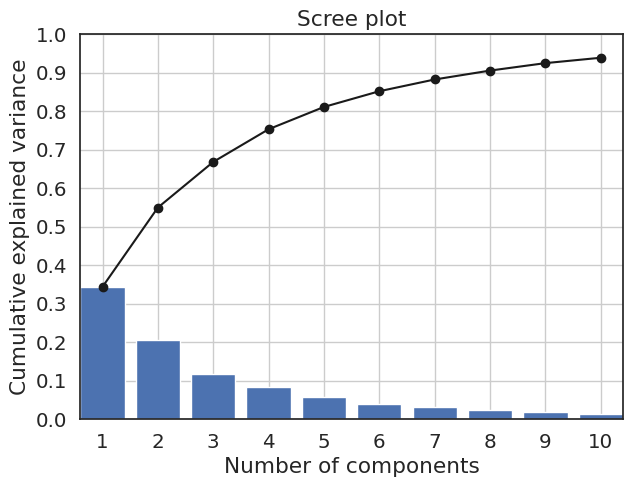

In [222]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(np.arange(1, n_components+1), np.cumsum(pca_step.explained_variance_ratio_), '-ok')
ax.bar(np.arange(1, n_components+1), pca_step.explained_variance_ratio_)
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance')
ax.set_title('Scree plot')
ax.set_xticks(np.arange(1, n_components+1))
ax.set_yticks(np.linspace(0, 1, 11))
ax.margins(x=0)
ax.grid()

In [223]:
plt.rcParams.update({'font.size': 15})

In [224]:
loadings = pd.DataFrame(pca_step.components_.T[:, :2], index=hifs_reduced.columns, columns=['PC1', 'PC2'])
loadings['HIF type'] = loadings.index.map(utils.get_hif_type)
loadings['Tissue type'] = loadings.index.map(utils.get_tissue)
loadings['Cell type'] = loadings.index.map(utils.get_cell)

In [225]:
loadings.sort_values(by=['PC1'], key=abs, ascending=False)[:10]

,PC1,PC2,HIF type,Tissue type,Cell type
DENSITY [HARMONIZED IMMUNE CELLS] IN [CANCER STROMA]_H & E,0.208901,-0.007767,DENSITY,CANCER STROMA,HARMONIZED IMMUNE
DENSITY [MACROPHAGE CELLS] IN [CANCER STROMA]_H & E,0.205019,-0.033786,DENSITY,CANCER STROMA,MACROPHAGE
DENSITY [MACROPHAGE CELLS] IN [HARMONIZED TUMOR]_H & E,0.204440,0.052548,DENSITY,HARMONIZED TUMOR,MACROPHAGE
COUNT PROP [[HARMONIZED IMMUNE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E,0.200126,0.106130,COUNT PROP,HARMONIZED TUMOR,HARMONIZED IMMUNE
COUNT PROP [[HARMONIZED IMMUNE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,0.199451,-0.055061,COUNT PROP,CANCER STROMA,HARMONIZED IMMUNE
DENSITY [LYMPHOCYTE CELLS] IN [CANCER STROMA]_H & E,0.198100,-0.006376,DENSITY,CANCER STROMA,LYMPHOCYTE
DENSITY [HARMONIZED IMMUNE CELLS] IN [HARMONIZED TUMOR]_H & E,0.197705,0.080359,DENSITY,HARMONIZED TUMOR,HARMONIZED IMMUNE
COUNT PROP [[MACROPHAGE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E,0.197344,0.054857,COUNT PROP,HARMONIZED TUMOR,MACROPHAGE
DENSITY [HARMONIZED ALL PREDICTED CELLS] IN [CANCER STROMA]_H & E,0.190999,-0.028056,DENSITY,CANCER STROMA,HARMONIZED ALL PREDICTED
DENSITY [LYMPHOCYTE CELLS] IN [HARMONIZED TUMOR]_H & E,0.184616,0.081028,DENSITY,HARMONIZED TUMOR,LYMPHOCYTE


In [226]:
loadings.sort_values(by=['PC2'], key=abs, ascending=False)[:5]

,PC1,PC2,HIF type,Tissue type,Cell type
COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E,-0.059686,-0.277406,COUNT PROP,HARMONIZED TUMOR,CANCER
AREA PROP [[CANCER STROMA] OVER [HARMONIZED TISSUE]]_H & E,-0.034734,0.276800,AREA PROP,CANCER STROMA,None
AREA PROP [[CANCER] OVER [HARMONIZED TUMOR]]_H & E,0.030136,-0.276495,AREA PROP,CANCER,None
AREA PROP [[CANCER STROMA] OVER [HARMONIZED TUMOR]]_H & E,-0.030136,0.276495,AREA PROP,CANCER STROMA,None
AREA PROP [[CANCER] OVER [HARMONIZED TISSUE]]_H & E,0.026595,-0.275816,AREA PROP,CANCER,None


Text(0, 0.5, 'PC 2 (20.6%)')

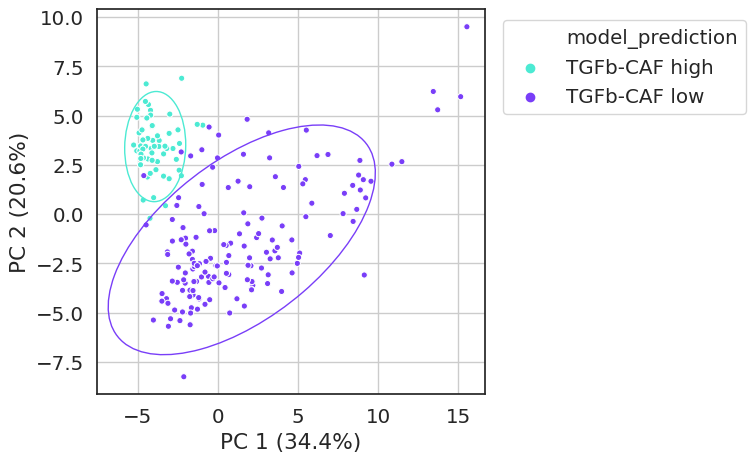

In [227]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(ax=ax, data=pca_data.iloc[:, :2], x='PC1', y='PC2', hue=model_prediction, 
                palette=colormap_tgfbeta, s=20)
huecol = 'model_prediction'
order = pca_data[huecol].value_counts().index

for s in order:
    pdata = pca_data.groupby(huecol).get_group(s)
    x = pdata['PC1']
    y = pdata['PC2']
    plot_utils.confidence_ellipse(x, y, ax, n_std=2, edgecolor=colormap_tgfbeta[s])
    
ax.legend(loc='center right', bbox_to_anchor=(1.7, 0.85), ncol=1)
ax.grid()
ax.set_xlabel(f'PC 1 ({pca_step.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC 2 ({pca_step.explained_variance_ratio_[1]*100:.1f}%)')
#fig.savefig('output/fig_4c_pca_plot_harmonized_by_model_pred.svg', bbox_inches='tight', dpi=500, facecolor='white')

In [228]:
feat1 = 'DENSITY [HARMONIZED IMMUNE CELLS] IN [CANCER STROMA]_H & E'
feat2 = 'COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E'
feat3 = 'AREA PROP [[CANCER STROMA] OVER [HARMONIZED TISSUE]]_H & E'

In [229]:
np.max(hifs_reduced[feat1])

11417.255859375

/opt/conda/lib/python3.10/site-packages/seaborn/relational.py:913: UserWarning:

No data for colormapping provided via 'c'. Parameters 'norm' will be ignored

/opt/conda/lib/python3.10/site-packages/seaborn/relational.py:950: UserWarning:

No data for colormapping provided via 'c'. Parameters 'norm' will be ignored

/tmp/ipykernel_2502/1692218538.py:8: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



Text(0, 0.5, 'PC 2 (20.6%)')

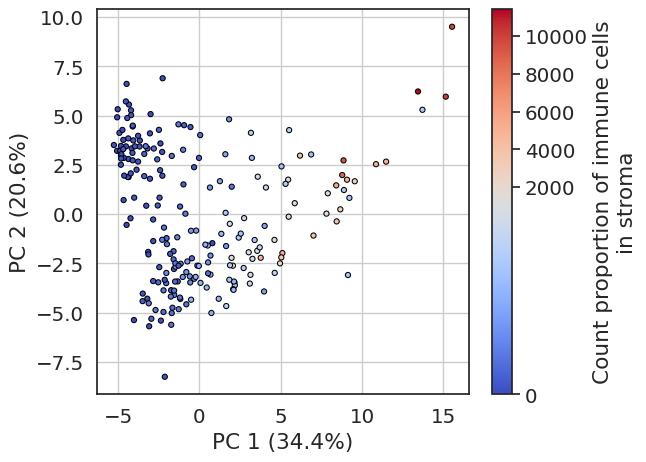

In [230]:
feat1_label = 'Count proportion of immune cells\nin stroma'
fig, ax = plt.subplots(figsize=(6, 5))
plot_data = pca_data.iloc[:, :2].merge(hifs_reduced[feat1], on='H & E_ID')
divnorm = colors.TwoSlopeNorm(vmin=0, vmax=np.max(hifs_reduced[feat1]), 
                              vcenter=np.nanmedian(plot_data[feat1]))
sns.scatterplot(ax=ax, data=plot_data, x='PC1', y='PC2', hue=feat1, 
                palette='coolwarm', norm=divnorm, s=14, edgecolor="black")
ax.figure.colorbar(plt.cm.ScalarMappable(norm=divnorm, cmap='coolwarm'), # cmap='seismic'
                   label=feat1_label)
ax.get_legend().remove()
ax.grid()
#ax.set_xlim(-8.5, 21)
#ax.set_xticks(np.linspace(-5, 20, 6))
ax.set_xlabel(f'PC 1 ({pca_step.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC 2 ({pca_step.explained_variance_ratio_[1]*100:.1f}%)')
#fig.savefig('output/pca_plot_harmonized_by_count_prop_immune_in_tumor.png', bbox_inches='tight', dpi=500, facecolor='white')

/opt/conda/lib/python3.10/site-packages/seaborn/relational.py:913: UserWarning:

No data for colormapping provided via 'c'. Parameters 'norm' will be ignored

/opt/conda/lib/python3.10/site-packages/seaborn/relational.py:950: UserWarning:

No data for colormapping provided via 'c'. Parameters 'norm' will be ignored

/tmp/ipykernel_2502/3681426485.py:8: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



Text(0, 0.5, 'PC 2 (20.6%)')

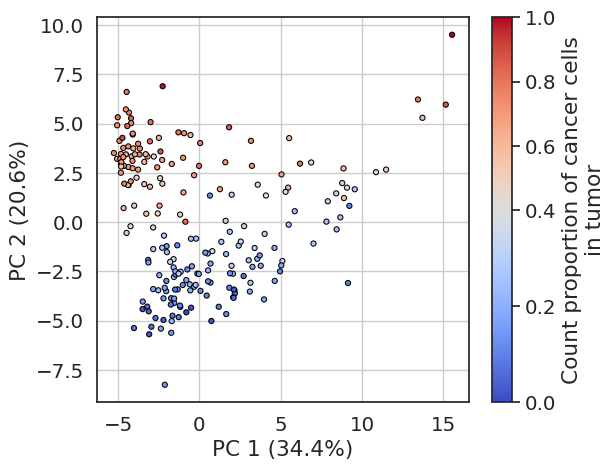

In [231]:
feat3_label = 'Count proportion of cancer cells\nin tumor'
fig, ax = plt.subplots(figsize=(6, 5))
plot_data = pca_data.iloc[:, :3].merge(hifs_reduced[feat3], on='H & E_ID')
divnorm = colors.TwoSlopeNorm(vmin=0, vmax=1, 
                              vcenter=np.nanmedian(plot_data[feat3]))
sns.scatterplot(ax=ax, data=plot_data, x='PC1', y='PC2', hue=feat3, 
                palette='coolwarm', norm=divnorm, s=14, edgecolor="black")
ax.figure.colorbar(plt.cm.ScalarMappable(norm=divnorm, cmap='coolwarm'), # cmap='seismic'
                   label=feat3_label)
ax.get_legend().remove()
ax.grid()
#ax.set_xlim(-8.5, 21)
#ax.set_xticks(np.linspace(-5, 20, 6))
ax.set_xlabel(f'PC 1 ({pca_step.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC 2 ({pca_step.explained_variance_ratio_[1]*100:.1f}%)')
#fig.savefig('output/pca_plot_harmonized_by_count_prop_fibroblast_in_stroma.png', bbox_inches='tight', dpi=500, facecolor='white')